In [1]:
import rasterio
import numpy as np
import pandas as pd

import pystac_client 
import planetary_computer as pc

import dask
import dask_gateway
import dask.array as da

from dask.distributed import Client

In [2]:
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

itemid = 'ca_m_3412037_nw_10_060_20180913_20190208',  # dangermond
search = catalog.search(
    collections=["naip"],
    ids = itemid)

item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
scene = rasterio.open(href).read([1,2,3,4])

1 Gibibye (GiB) = 1024 Mebibyte (MiB)

Mebibyte = 1,048,576 bytes

Megabyte ~ 1,000,000 bytes

For performance, a good choice of chunks follows the following rules:

A chunk should be small enough to fit comfortably in memory. We’ll have many chunks in memory at once
A chunk must be large enough so that computations on that chunk take significantly longer than the 1ms overhead per task that Dask scheduling incurs. A task should take longer than 100ms
Chunk sizes between 10MB-1GB are common, depending on the availability of RAM and the duration of computations

https://docs.dask.org/en/latest/array-chunks.html

In [3]:
dask_scene = da.from_array(scene, chunks='auto')
dask_scene

dask.array<array, shape=(4, 12310, 10360), dtype=uint8, chunksize=(4, 5792, 5180), chunktype=numpy.ndarray>

In [13]:
#dask_scene.chunks

In [15]:
dask_scene.blocks[0,2,1]

dask.array<blocks, shape=(4, 726, 5180), dtype=uint8, chunksize=(4, 726, 5180), chunktype=numpy.ndarray>

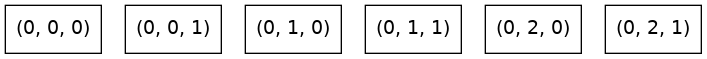

In [4]:
dask_scene.visualize()

In [13]:
dask_scene.dask

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f91a8c64d90>
 0. array-3f8d7a29c200124393e0b5d7b9c94c58

# Generate task graph

In [17]:
lazy_results = []
params = [dask_scene.blocks[0,0,0],dask_scene.blocks[0,0,1],
          dask_scene.blocks[0,1,0],dask_scene.blocks[0,1,1]]
#a = select_ndvi_df(dask_scene)

for parameter in params:
    lazy_result = dask.delayed(select_ndvi_df)(parameter)
    lazy_results.append(lazy_result)
lazy_results

[Delayed('select_ndvi_df-6571b051-698e-4ac0-bc52-e93448723983'),
 Delayed('select_ndvi_df-41dc8bb1-3784-440c-9c74-4d12bc820b16'),
 Delayed('select_ndvi_df-5263bd8a-1a18-4091-ba1e-c13f635e7b06'),
 Delayed('select_ndvi_df-2b430d0b-ab94-479e-ac35-82575bd3555b')]

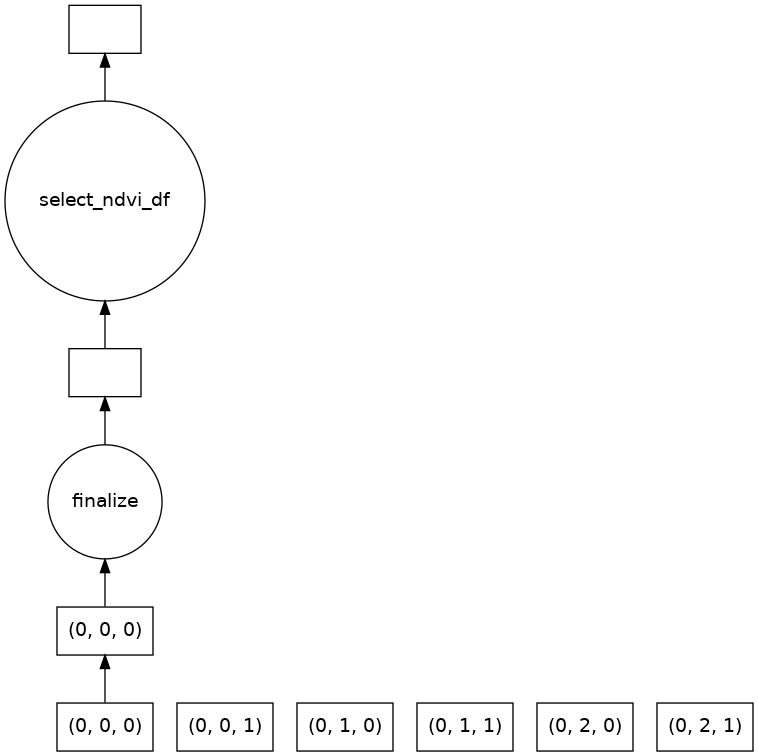

In [19]:
lazy_results[0].visualize()

In [ ]:
type(lazy_results[0])

dask.delayed.Delayed

# Initialize Client

After you have generated a task graph, it is the scheduler’s job to execute it.

By default when you call compute on a Dask object, Dask uses the thread pool on your computer to run computations in parallel.

In [5]:
from dask.distributed import Client, progress
#client = Client(threads_per_worker=4, n_workers=1)
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/msai4earth-esa/iceplant_detection/dask-worker-space/worker-u34eq9ki', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/msai4earth-esa/iceplant_detection/dask-worker-space/worker-43kefapp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33893,Workers: 4
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33067,Total threads: 1
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/39135/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:43341,


In [ ]:
#client.dashboard_link

'/user/c_galazgarcia@ucsb.edu/proxy/8787/status'

In [23]:
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# #cluster.scale(4)
# print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.948103c425724db58852775ddca79723/status


In [ ]:
#dask.compute(*lazy_results)

In [19]:
type(x)

dask.array.core.Array

In [7]:
x = dask_scene.map_blocks(lambda x: x*2)
x

dask.array<lambda, shape=(4, 12310, 10360), dtype=uint8, chunksize=(4, 5792, 5180), chunktype=numpy.ndarray>

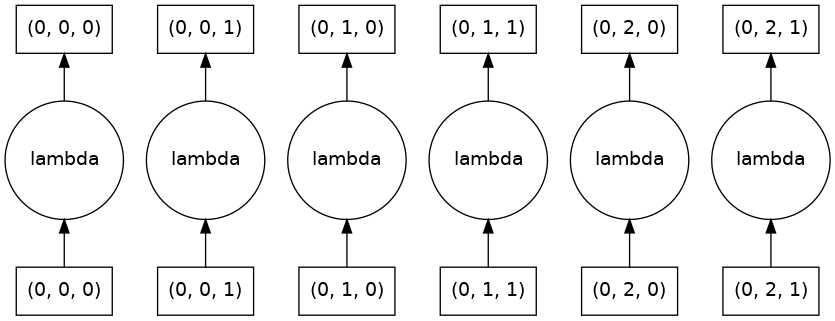

In [8]:
x.visualize()

In [11]:
y = x.compute()
y

In [14]:
y.shape

(4, 12310, 10360)

In [ ]:
def compute_ndvi(image, thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation

In [ ]:
y = da.map_blocks(compute_ndvi, dask_scene, dtype=np.float_)

In [4]:
def ndvi(rgbnir):
    if rgbnir.shape == (1,):
        return 0
    x = rgbnir.astype('int16')
    return (x[3] - x[0])/(x[3] + x[0])

https://stackoverflow.com/questions/61932448/dask-apply-along-axis-error-comparison-with-numpy

https://github.com/dask/dask/pull/3742

In [5]:
z = da.apply_along_axis(ndvi, 0 , dask_scene, dtype='float')#, shape=(dask_scene.shape[1],dask_scene.shape[2]))

In [ ]:
z.compute()